# Bitcoin Price Prediction with Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime

%matplotlib inline


<br>

    I will use bitstamp data it can be downloaded from; https://www.kaggle.com/mczielinski/bitcoin-historical-data . Metadata also can be found in this link. 

<br>


In [2]:
bitcoin_df = pd.read_csv("./bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")

## Exploring and Clearing the Data

In [3]:
type(bitcoin_df)


pandas.core.frame.DataFrame

In [4]:
bitcoin_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
bitcoin_df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')

In [6]:
# I will not need all the columns, closing price and time stamp enough for me

selected_df = bitcoin_df[['Timestamp','Close']].copy()
selected_df.head()

,Timestamp,Close
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


In [7]:
# from timestamp to date
selected_df['Timestamp'] = pd.to_datetime(selected_df['Timestamp'], unit="s")

In [8]:
# The data contains every minute. I need daiyly close data. (yyyy-mm-dd 23:59:00)
selected_df[960:970]

,Timestamp,Close
960,2011-12-31 23:52:00,NaN
961,2011-12-31 23:53:00,NaN
962,2011-12-31 23:54:00,NaN
963,2011-12-31 23:55:00,NaN
964,2011-12-31 23:56:00,NaN
965,2011-12-31 23:57:00,NaN
966,2011-12-31 23:58:00,NaN
967,2011-12-31 23:59:00,NaN
968,2012-01-01 00:00:00,NaN
969,2012-01-01 00:01:00,NaN


In [9]:
# Creating new columns from date data for masking
selected_df["hour"] = selected_df.Timestamp.dt.hour

In [10]:
selected_df["minute"] = selected_df.Timestamp.dt.minute

In [11]:
selected_df.head()

,Timestamp,Close,hour,minute
0,2011-12-31 07:52:00,4.39,7,52
1,2011-12-31 07:53:00,NaN,7,53
2,2011-12-31 07:54:00,NaN,7,54
3,2011-12-31 07:55:00,NaN,7,55
4,2011-12-31 07:56:00,NaN,7,56


In [12]:
hour_mask = selected_df["hour"] == 23 
hour_mask.head()

0    False
1    False
2    False
3    False
4    False
Name: hour, dtype: bool

In [13]:
minute_mask = selected_df["minute"] == 59
minute_mask.head()

0    False
1    False
2    False
3    False
4    False
Name: minute, dtype: bool

In [14]:
btc_day_df = selected_df[hour_mask & minute_mask]
btc_day_df.head()

,Timestamp,Close,hour,minute
967,2011-12-31 23:59:00,NaN,23,59
2407,2012-01-01 23:59:00,NaN,23,59
3847,2012-01-02 23:59:00,NaN,23,59
5287,2012-01-03 23:59:00,NaN,23,59
6727,2012-01-04 23:59:00,NaN,23,59


In [15]:
# No need for hour and minute column
del btc_day_df["hour"]
del btc_day_df["minute"]
btc_day_df.shape

(2625, 2)

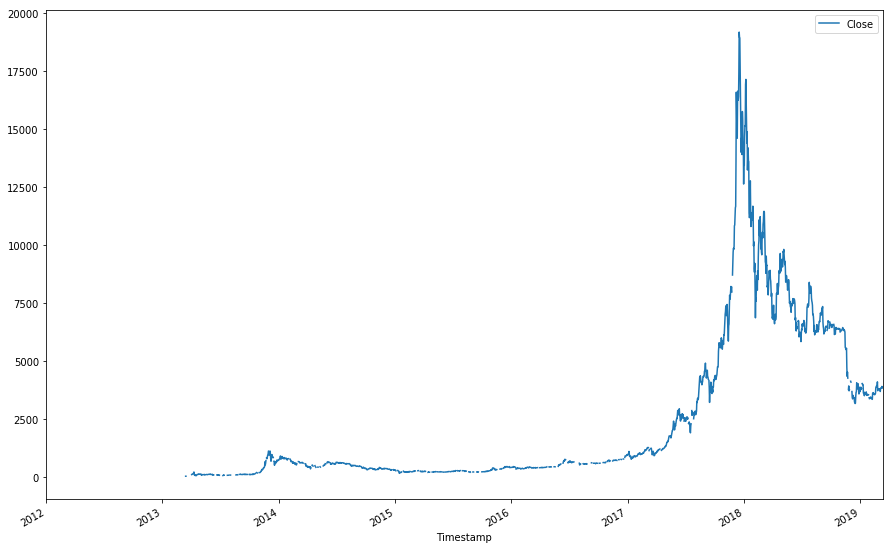

In [16]:
#Lets look it on a chart
btc_day_df.plot(x="Timestamp", y="Close", figsize=(15,10))

### Short comments:

        1. We lost nearly 3 years of data. Best thing to do is search for new data to fulfill the missing days. But for now I will continue with this data set. 
    
        2. In addition, We do not have consistent data before April 2013 I will delete the data before April 2013.

In [17]:
#deleting part of data
grater_than = btc_day_df["Timestamp"] > "2013-04-01"

btc_day_df = btc_day_df[grater_than]

In [18]:
#Let's clear NaN's
btc_day_df = btc_day_df.dropna()

In [19]:
btc_day_df

,Timestamp,Close
660487,2013-04-02 23:59:00,116.00
661927,2013-04-03 23:59:00,133.78
663367,2013-04-04 23:59:00,135.00
664807,2013-04-05 23:59:00,141.80
666247,2013-04-06 23:59:00,141.00
667687,2013-04-07 23:59:00,164.97
669127,2013-04-08 23:59:00,185.60
670567,2013-04-09 23:59:00,229.00
672007,2013-04-10 23:59:00,162.00
673447,2013-04-11 23:59:00,83.40


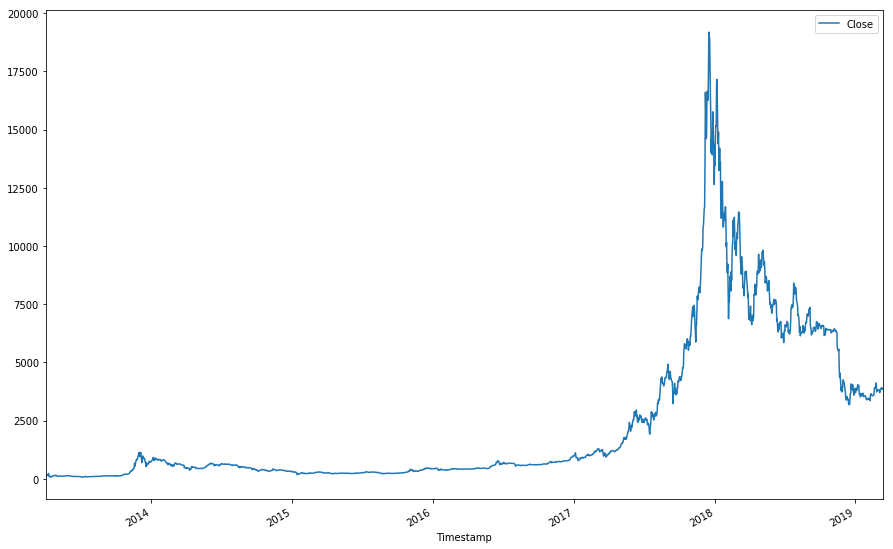

In [20]:
#Lets plot again
btc_day_df.plot(x="Timestamp", y="Close", figsize=(15,10))

In [21]:
btc_day_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,1696.0,2766.065778,3582.117258,66.93,377.7675,689.405,4276.625,19187.78



        It is already look like very unpredictible with the standard deviation 3500 ish and 66.93 min, 19000 max. I am excited to see the result with this data set. In the future I may try it with more recent data. I must defenetaly try to chose more limited training data and try to lower the std or maybe normalize the data.

In [22]:
# No need for timestamp, let's remove it
del btc_day_df["Timestamp"]

# Training the model and predicting

In [23]:
# Feature dataframe
X = btc_day_df[0:1695].copy()

In [24]:
# Targeted dataframe
y = btc_day_df[1:1696].copy()

In [26]:
print("First three row of x:\n\n", X[:3], "\n\n")
print("Last three row of x:\n\n", X[-3:])

First three row of x:

          Close
660487  116.00
661927  133.78
663367  135.00 


Last three row of x:

            Close
3774495  3916.43
3775935  3897.92
3777375  3849.25


In [27]:
print("First three row of y:\n\n", y[:3], "\n\n")
print("Last three row of y:\n\n", y[-3:])

First three row of y:

          Close
661927  133.78
663367  135.00
664807  141.80 


Last three row of y:

            Close
3775935  3897.92
3777375  3849.25
3778815  3859.74


In [29]:
# Split the Dataset into Training and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Linear Regression:

In [30]:
#  Fit a model to the training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [31]:
y_prediction = regressor.predict(X_test)
y_prediction

array([[  288.89005606],
       [  438.32563171],
       [12776.0022563 ],
       [ 4229.34494445],
       [  699.41054472],
       [  784.37959903],
       [  457.57861978],
       [ 2836.34227529],
       [  610.91277556],
       [  476.54171343],
       [   96.27020811],
       [  327.60595575],
       [  131.99719636],
       [ 1724.31727422],
       [ 7083.02563542],
       [ 6590.44503302],
       [ 6882.76856894],
       [  650.41838763],
       [10903.82410261],
       [  608.55363476],
       [14999.19257155],
       [ 1653.60302831],
       [  381.0564891 ],
       [ 7332.83465511],
       [ 6139.79915802],
       [  420.82200652],
       [  241.70724002],
       [  741.15534128],
       [  577.36499364],
       [  396.29094072],
       [ 1028.28077035],
       [  131.16749854],
       [ 3682.25419461],
       [  330.04506743],
       [  667.94200554],
       [  142.17349016],
       [ 1273.20157032],
       [  106.62643638],
       [15142.82026242],
       [  348.44836496],


In [32]:
# evaluating the accuracy by root mean square error
rmse = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))

In [33]:
print(rmse)

271.31230207707824


## Decision Tree Regressor:

In [34]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [35]:
y_prediction = regressor.predict(X_test)
y_prediction

array([  310.55 ,   443.36 , 13781.41 ,  4140.39 ,   787.   ,   807.47 ,
         433.07 ,  2899.99 ,   593.4  ,   476.57 ,    91.55 ,   324.2  ,
         103.85 ,  1782.99 ,  7469.45 ,  6517.55 ,  7737.37 ,   634.11 ,
       11250.   ,   608.   , 13243.83 ,  1784.   ,   363.06 ,  7347.39 ,
        5848.33 ,   521.   ,   256.99 ,   732.   ,   560.4  ,   384.86 ,
         814.91 ,   127.71 ,  3536.72 ,   361.26 ,   653.48 ,   149.   ,
        1273.   ,   100.   , 14470.07 ,   348.9  ,   367.17 , 16404.99 ,
         230.52 ,   361.3  ,   687.81 ,  9242.17 ,  6749.45 ,   642.26 ,
       10324.7  ,  7719.62 ,  2013.99 ,   236.87 ,  6411.96 ,  4101.6  ,
        6479.27 ,   607.46 ,   282.8  ,   415.85 ,  4184.84 ,   226.12 ,
        6612.98 ,  3851.55 ,   930.34 ,   122.5  ,  6437.29 ,   986.   ,
         417.62 ,   394.52 ,  6215.59 ,  2303.71 ,  8231.2  ,  6588.18 ,
         123.74 ,   229.03 ,  6880.61 ,   425.   ,  4155.67 ,   257.62 ,
        7896.92 ,  6407.66 ,  4378.84 ,  6749.45 , 

In [36]:
rmse = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))

In [37]:
print(rmse)

392.2537129880376


# Results

1. It is really hard to predict bitcoin price, predicting with just daily closing price just does not work.
2. I need to collect more updated data and update the data set.
3. Lineer regression is better than desicion tree regression, plus I migth consider to fit a logaritmic regression model.
4. I must find the ways to include more data, like google search data, volume data, twitter data etc.